In [2]:
%pylab inline

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:

import tensorflow as tf
import tensorflow_probability as tfp
import mesh_tensorflow as mtf

import flowpm
import flowpm.mesh_ops as mpm
import flowpm.mtfpm as mtfpm
import flowpm.mesh_utils as mesh_utils
from astropy.cosmology import Planck15
from flowpm.tfpm import PerturbationGrowth
from flowpm import linear_field, lpt_init, nbody, cic_paint
from flowpm.utils import r2c3d, c2r3d

sys.path.append('../utils/')
import tools
import diagnostics as dg

import contextlib
import functools
import math, time
from scipy.interpolate import InterpolatedUnivariateSpline as iuspline
import scipy.optimize as sopt



In [5]:
from tensorflow.python.keras import backend as K


In [6]:
from recurrent_inference import rim, ConvRIM3D
from convolutional_recurrent import ConvLSTM3DCell
from tensorflow.python.keras.layers import ConvLSTM2D
from tensorflow.python.keras.layers.convolutional_recurrent import ConvLSTM2DCell
from tensorflow.python.keras.layers import LSTMCell, LSTM, Dense, Conv3D



In [7]:
bs, nc = 100, 16
nsteps = 3
a0, a, nsteps = 0.1, 1.0,  nsteps
stages = np.linspace(a0, a, nsteps, endpoint=True)

klin = np.loadtxt('../data/Planck15_a1p00.txt').T[0]
plin = np.loadtxt('../data//Planck15_a1p00.txt').T[1]
ipklin = iuspline(klin, plin)
# Compute necessary Fourier kernels                                                                                                                           
kvec = tools.fftk((nc, nc, nc), boxsize=nc, symmetric=False)
kmesh = (sum(k**2 for k in kvec)**0.5).astype(np.float32)
priorwt = ipklin(kmesh)


In [8]:
dpath = '../data/rim-data/L%04d_N%03d_T%02d/'%(bs, nc, nsteps)

alldata = np.array([np.load(dpath + '%04d.npy'%i) for i in range(1000)]).astype(float32)

# alldata = np.expand_dims(alldata, axis=2)

traindata, testdata = alldata[:900], alldata[900:]
ic, fin = traindata[:1,0], traindata[:1,1]


In [9]:
def get_ps(iterand, truth):
    ic, fin = truth
    ic1, fin1 = iterand

    pks = []
    if abs(ic1[0].mean()) < 1e-3: ic1[0] += 1
    #if abs(ic[0].mean()) < 1e-3: ic[0] += 1                                                                                                                  
    k, p1 = tools.power(ic1[0]+1, boxsize=bs)
    k, p2 = tools.power(ic[0]+1, boxsize=bs)
    k, p12 = tools.power(ic1[0]+1, f2=ic[0]+1, boxsize=bs)
    pks.append([p1, p2, p12])
    if fin1[0].mean() < 1e-3: fin1[0] += 1
    if fin[0].mean() < 1e-3: fin[0] += 1
    k, p1 = tools.power(fin1[0], boxsize=bs)
    k, p2 = tools.power(fin[0], boxsize=bs)
    k, p12 = tools.power(fin1[0], f2=fin[0], boxsize=bs)
    pks.append([p1, p2, p12])

    return k, pks


# GD

In [10]:
@tf.function
def pm(linear):
    state = lpt_init(linear, a0=0.1, order=1)
    final_state = nbody(state,  stages, nc)
    tfinal_field = cic_paint(tf.zeros_like(linear), final_state[0])
    return tfinal_field


@tf.function
def recon_prototype(linear, data, Rsm, anneal=True):
    """                                                                                                                                                   
    """
#     linear = tf.reshape(linear, data.shape)
    final_field = pm(linear)

    residual = final_field - data #.astype(np.float32)
    base = residual

    if anneal :
        print("\nAdd annealing section to graph\n")
        Rsmsq = tf.multiply(Rsm*bs/nc, Rsm*bs/nc)
        smwts = tf.exp(tf.multiply(-kmesh**2, Rsmsq))
        basek = r2c3d(base, norm=nc**3)
        basek = tf.multiply(basek, tf.cast(smwts, tf.complex64))
        base = c2r3d(basek, norm=nc**3)

    chisq = tf.multiply(base, base)
    chisq = tf.reduce_sum(chisq)
#     chisq = tf.multiply(chisq, 1/nc**3, name='chisq')

    #Prior                                                                                                                                                
    lineark = r2c3d(linear, norm=nc**3)
    priormesh = tf.square(tf.cast(tf.abs(lineark), tf.float32))
    prior = tf.reduce_sum(tf.multiply(priormesh, 1/priorwt))
#     prior = tf.multiply(prior, 1/nc**3, name='prior')
    #                                                                                                                                                     
    loss = chisq + prior

    return loss


@tf.function
def recon_loss_and_grad(x, y, Rsm):
    print("val and grad : ", x.shape)
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = recon_prototype(x, y, Rsm)
    grad = tape.gradient(loss, x)
    return loss, grad

@tf.function
def recon_grad(x, y, Rsm):
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = recon_prototype(x, y, Rsm)
    grad = tape.gradient(loss, [x])
    return grad




@tf.function
def recon_prototype_noanneal(linear, data):
    """                                                                                                                                                   
    """
    print('new graph')
    final_field = pm(linear)

    residual = final_field - data #.astype(np.float32)

    chisq = tf.multiply(residual, residual)
    chisq = tf.reduce_mean(chisq)
#     chisq = tf.multiply(chisq, 1/nc**3, name='chisq')

    #Prior                                                                                                                                                
    lineark = r2c3d(linear, norm=nc**3)
    priormesh = tf.square(tf.cast(tf.abs(lineark), tf.float32))
    prior = tf.reduce_mean(tf.multiply(priormesh, 1/priorwt))
#     prior = tf.multiply(prior, 1/nc**3, name='prior')
    #                                                                                                                                                     
    loss = chisq + prior

    return loss, chisq, prior


@tf.function
def recon_noanneal_grad(x, y):
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = recon_prototype_noanneal(x, y)[0]
    grad = tape.gradient(loss, x)
    return grad





In [11]:
RRs = [0]
niter = 100

# Create an optimizer for Adam.                                                                                                                           
opt = tf.keras.optimizers.Adam(learning_rate=0.1)
# opt = tf.keras.optimizers.SGD(learning_rate=100)

#Loop it Reconstruction                                                                                                                                   
##Reconstruction              a                                                                                                                            
x0 = np.random.normal(0, 1, nc**3).reshape(fin.shape).astype(np.float32)
linear = tf.Variable(name='linmesh', shape=(1, nc, nc, nc), dtype=tf.float32,
                         initial_value=x0, trainable=True)

for iR, RR in enumerate(RRs):

    for i in range(niter):
#         loss, chisq, prior = recon_prototype_noanneal(linear, tf.constant(fin, dtype=tf.float32))
#         print(i, loss.numpy(), chisq.numpy(), prior.numpy())

#         grads = recon_grad(linear, tf.constant(fin, dtype=tf.float32), tf.constant(RR, dtype=tf.float32))
#         opt.apply_gradients(zip(grads, [linear]))

        grads = recon_noanneal_grad(linear, tf.constant(fin, dtype=tf.float32))
        opt.apply_gradients(zip([grads], [linear]))
    minic = linear.numpy().reshape(fin.shape)
    
    x0 = minic
    
minfin = pm(tf.constant(minic)).numpy()

new graph


In [336]:
# RRs = [0]
# niter = 20

# # Create an optimizer for Adam.                                                                                                                           
# # opt = tf.keras.optimizers.Adam(learning_rate=0.1)
# opt_sgd = tf.keras.optimizers.SGD(learning_rate=0.1)
# opt_adam = tf.keras.optimizers.Adam(learning_rate=0.1)

# #Loop it Reconstruction                                                                                                                                   
# ##Reconstruction              a                                                                                                                            
# x0 = np.random.normal(0, 1, nc**3).reshape(fin.shape).astype(np.float32)
# linear = tf.Variable(name='linmesh', shape=(1, nc, nc, nc), dtype=tf.float32,
#                          initial_value=x0, trainable=True)
# linear1 = tf.Variable(name='linmesh2', shape=(1, nc, nc, nc), dtype=tf.float32,
#                          initial_value=x0, trainable=True)

# steps_adam, steps_sgd = [], []

# for iR, RR in enumerate(RRs):

#     for i in range(niter):
# #         loss, chisq, prior = recon_prototype_noanneal(linear, tf.constant(fin, dtype=tf.float32))
# #         print(i, loss.numpy(), chisq.numpy(), prior.numpy())

# #         grads = recon_grad(linear, tf.constant(fin, dtype=tf.float32), tf.constant(RR, dtype=tf.float32))
# #         opt.apply_gradients(zip(grads, [linear]))
#         l0 = linear.numpy()
#         grads = recon_noanneal_grad(linear, tf.constant(fin, dtype=tf.float32))
#         opt_adam.apply_gradients(zip([grads], [linear]))
#         l1 = linear.numpy()
#         steps_adam.append(l1-l0)
        
#         l0 = linear1.numpy()
#         opt_sgd.apply_gradients(zip([grads], [linear1]))
#         l1 = linear1.numpy()
#         steps_sgd.append(l1-l0)
        
#         linear1.assign(linear.numpy())
#     minic = linear.numpy().reshape(fin.shape)
    
#     x0 = minic
    
# minfin = pm(tf.constant(minic)).numpy()

new graph


In [12]:
b1, b2 = 0.9, 0.999
m = 0 
v = 0
t = 1
eps = 1e-7
lr  = 0.1
##Reconstruction              a                                                                                                                            
linear3 = tf.Variable(name='linmesh', shape=(1, nc, nc, nc), dtype=tf.float32,
                initial_value=x0, trainable=True)

for i in range(niter):
    
    t = i+1
    grads = recon_noanneal_grad(linear3, tf.constant(fin, dtype=tf.float32))

    m = b1*m + (1-b1)*grads.numpy()
    v = b2*v + (1-b2)*grads.numpy()**2
    mc = m/(1-b1**t)
    vc = v/(1-b2**t)
    delta = lr*mc/(np.sqrt(vc) + 1e-7)

    linear3 = linear3 - delta
    

minic3 = linear3.numpy().reshape(fin.shape)

x3 = minic3

minfin3 = pm(tf.constant(minic3)).numpy()




new graph
new graph


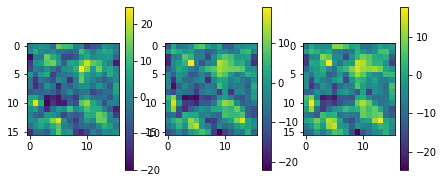

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(7, 3))
im = ax[0].imshow(ic[0].sum(axis=0))
plt.colorbar(im, ax=ax[0])
im = ax[1].imshow(minic[0].sum(axis=0))
plt.colorbar(im, ax=ax[1])
im = ax[2].imshow(minic3[0].sum(axis=0))
plt.colorbar(im, ax=ax[2])

No handles with labels found to put in legend.
No handles with labels found to put in legend.


(<Figure size 864x252 with 3 Axes>,
 array([<AxesSubplot:xlabel='k (h/Mpc)', ylabel='P(k)'>,
        <AxesSubplot:xlabel='k (h/Mpc)', ylabel='Cross correlation'>,
        <AxesSubplot:xlabel='k (h/Mpc)', ylabel='Transfer Function'>],
       dtype=object))

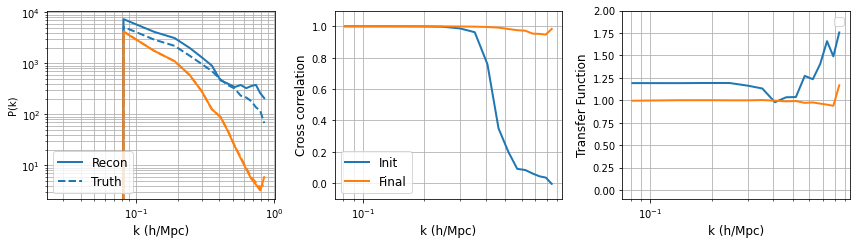

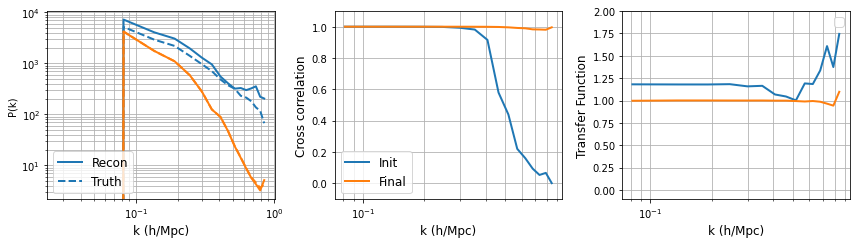

In [14]:
dg.save2ptfig(0, [minic, minfin], [ic, fin], None, bs, save=False, retfig=True)
dg.save2ptfig(0, [minic3, minfin3], [ic, fin], None, bs, save=False, retfig=True)


In [339]:
# x0 = np.random.normal(0, 1, nc**3).reshape(fin.shape).astype(np.float32)
# linear = tf.Variable(name='linmesh', shape=(1, nc, nc, nc), dtype=tf.float32,
#                          initial_value=x0, trainable=True)


# RR = 0
# xinitrecons = []
# for j in range(traindata.shape[0]):
#     linear.assign(x0)
#     for i in range(5):
#         grads = recon_noanneal_grad(linear, tf.constant(traindata[j:j+1, 1], dtype=tf.float32))
#         opt.apply_gradients(zip([grads], [linear]))
#     minic = linear.numpy().reshape(fin.shape)
#     xinitrecons.append(linear.numpy().reshape(fin.shape))
# xinitrecons_train = np.array(xinitrecons)

In [340]:
# x0 = np.random.normal(0, 1, nc**3).reshape(fin.shape).astype(np.float32)
# linear = tf.Variable(name='linmesh', shape=(1, nc, nc, nc), dtype=tf.float32,
#                          initial_value=x0, trainable=True)


# RR = 0
# xinitrecons2 = []
# for j in range(testdata.shape[0]):
# # for j in range(10):
#     linear.assign(x0)
#     for i in range(5):
#         grads = recon_noanneal_grad(linear, tf.constant(testdata[j:j+1, 1], dtype=tf.float32))
#         opt.apply_gradients(zip([grads], [linear]))
#     minic = linear.numpy().reshape(fin.shape)
#     xinitrecons2.append(linear.numpy().reshape(fin.shape))
# xinitrecons_test = np.array(xinitrecons2)

In [16]:
# kvecreal = tools.fftk((nc, nc, nc), bs)
# xinitrecons_train = np.array([tools.gauss(i, kvecreal, 2) 
#                               for i in xinitrecons_train[:,0]]).astype(float32)
# xinitrecons_train = np.expand_dims(xinitrecons_train, 1)
# xinitrecons_test = np.array([tools.gauss(i, kvecreal, 2) 
#                              for i in xinitrecons_test[:, 0]]).astype(float32)
# xinitrecons_test = np.expand_dims(xinitrecons_test, 1)

No handles with labels found to put in legend.


(<Figure size 864x252 with 3 Axes>,
 array([<AxesSubplot:xlabel='k (h/Mpc)', ylabel='P(k)'>,
        <AxesSubplot:xlabel='k (h/Mpc)', ylabel='Cross correlation'>,
        <AxesSubplot:xlabel='k (h/Mpc)', ylabel='Transfer Function'>],
       dtype=object))

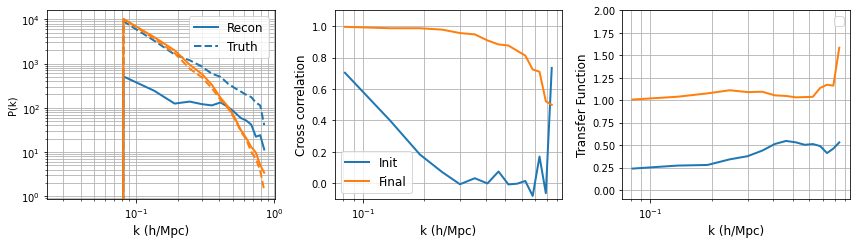

In [17]:
# jj =  200
# # dg.save2ptfig(0, [xinitrecons_test[jj], minfin], [testdata[jj:jj+1, 0], fin], None, bs, save=False, retfig=True)
# dg.save2ptfig(0, [xinitrecons_train[jj], minfin], [traindata[jj:jj+1, 0], fin], None, bs, save=False, retfig=True)

# # plt.imshow(xinitrecons[1][0].sum(axis=0))

# Code RIM

In [204]:
# class myRIM3D(tf.keras.Model):

#     def __init__(self, cell, output_layer, input_layer, lrgrad, niter):
#         super(myRIM3D, self).__init__()
#         self.cell = cell
#         self.output_layer = output_layer
#         self.input_layer = input_layer
#         self.lrgrad = lrgrad
#         self.niter = niter

            
# #     def call(self, x_init, y, grad_fn, outputs_ta, states_ta, grad_args=[], initstates = None, return_steps=False):
#     def call(self, x_init, y, grad_fn, grad_args=[], initstates = None, return_steps=False):
        
#         outputs_ta = tf.TensorArray(size=self.niter+1, dtype=tf.float32)
#         states_ta = tf.TensorArray(size=self.niter+1, dtype=tf.float32)
        
#         if initstates is None: 
# #             stateshape = x_init.shape[:-1] + tuple([self.cell.output_size])
#             stateshape = x_init.shape + tuple([self.cell.filters])
#             initstates = [tf.zeros(stateshape), tf.zeros(stateshape)]
    
#         i = tf.constant(0, dtype=tf.int32)
#         curr_state = initstates
#         curr_pos = x_init
        
        
#         def body(i, pos, states):  
#             gradient = grad_fn(pos, y, *grad_args)
#             gradient = gradient * self.lrgrad
#             concat_input = tf.stack([pos, gradient], axis=-1)
#             cell_input = self.input_layer(concat_input)
#             delta_pos, new_state = self.cell(cell_input, states)
#             delta_pos = self.output_layer(delta_pos)[...,0]
#             new_pos = pos + delta_pos
#             return i +1 , new_pos, new_state
        
#         while tf.less(i, tf.constant(self.niter)):
#             outputs_ta = outputs_ta.write(i, curr_pos)
#             states_ta = states_ta.write(i, curr_state)
#             i, curr_pos, curr_state =  body(i, curr_pos, curr_state)
#         outputs_ta = outputs_ta.write(i, curr_pos)
#         states_ta = states_ta.write(i, curr_state)
#         return outputs_ta.stack(), states_ta.stack()


In [15]:

class myAdam(tf.keras.Model):

    def __init__(self, niter):
        super(myAdam, self).__init__()
        self.niter = niter
        self.beta_1, self.beta_2 = 0.9, 0.999
        self.lr, self.eps = 0.1, 1e-7
            
            
    def call(self, x_init, y, grad_fn, grad_args=[], ):
        
        outputs_ta = tf.TensorArray(size=self.niter+1, dtype=tf.float32)
            
        i = tf.constant(0, dtype=tf.int32)
        curr_pos = x_init        
        m = tf.zeros_like(x_init)
        v = tf.zeros_like(x_init)
        
        def body(i, pos, m, v):  
            gradient = grad_fn(pos, y, *grad_args)           
            #get_step = self.optimizer.apply_gradients(zip([gradient],[ pos]))

            t = tf.cast(i+1, tf.float32)
            m = self.beta_1*m + (1-self.beta_1)*gradient
            v = self.beta_2*v + (1-self.beta_2)*gradient**2
            mc = m/(1-self.beta_1**t)
            vc = v/(1-self.beta_2**t)
            delta = -1.*self.lr*mc/(np.sqrt(vc) + self.eps)

            new_pos = pos + delta
            return i +1 , new_pos, m, v
        
        while tf.less(i, tf.constant(self.niter)):
            outputs_ta = outputs_ta.write(i, curr_pos)
            i, curr_pos,  m, v =  body(i, curr_pos,  m, v)
        outputs_ta = outputs_ta.write(i, curr_pos)
        return outputs_ta.stack()


In [20]:

class myRIM3D(tf.keras.Model):

    def __init__(self, cell, output_layer, input_layer, niter):
        super(myRIM3D, self).__init__()
        self.cell = cell
        self.output_layer = output_layer
        self.input_layer = input_layer
        self.niter = niter
        self.beta_1, self.beta_2 = 0.9, 0.999
        self.lr, self.eps = 0.1, 1e-7
            
            
    def call(self, x_init, y, grad_fn, grad_args=[], initstates = None, return_steps=False):
        
        outputs_ta = tf.TensorArray(size=self.niter+1, dtype=tf.float32)
        states_ta = tf.TensorArray(size=self.niter+1, dtype=tf.float32)
        
        if initstates is None: 
            stateshape = x_init.shape + tuple([self.cell.filters])
            initstates = [tf.zeros(stateshape), tf.zeros(stateshape)]
    
        i = tf.constant(0, dtype=tf.int32)
        curr_state = initstates
        curr_pos = x_init        
        m = tf.zeros_like(x_init)
        v = tf.zeros_like(x_init)
        
        def body(i, pos, states, m, v):  
            gradient = grad_fn(pos, y, *grad_args)           
            t = tf.cast(i+1, tf.float32)
            m = self.beta_1*m + (1-self.beta_1)*gradient
            v = self.beta_2*v + (1-self.beta_2)*gradient**2
            mc = m/(1-self.beta_1**t)
            vc = v/(1-self.beta_2**t)
            delta = -1.*self.lr*mc/(np.sqrt(vc) + self.eps)

            concat_input = tf.stack([pos, delta], axis=-1)
            cell_input = self.input_layer(concat_input)            
            delta_pos, new_state = self.cell(cell_input, states)
            delta_pos = self.output_layer(delta_pos)[...,0]
            new_pos = pos + delta_pos
            return i +1 , new_pos, new_state, m, v
        
        while tf.less(i, tf.constant(self.niter)):
            outputs_ta = outputs_ta.write(i, curr_pos)
            states_ta = states_ta.write(i, curr_state)
            i, curr_pos, curr_state, m, v =  body(i, curr_pos, curr_state, m, v)
        outputs_ta = outputs_ta.write(i, curr_pos)
        states_ta = states_ta.write(i, curr_state)
        return outputs_ta.stack(), states_ta.stack()


In [21]:
rim_iter = 10
input_size = 8
cell_size = 8 

input_layer = Conv3D(input_size, kernel_size=5, trainable=True, padding='SAME',
                     input_shape=(None, nc, nc, nc, 2))

cell = ConvLSTM3DCell(cell_size, kernel_size=5, padding='SAME')
cell.build(input_shape=[None, nc, nc, nc, input_size])

output_layer = Conv3D(1, kernel_size=5, trainable=True, padding='SAME', 
                     input_shape=(None, nc, nc, nc, cell_size))



idx = np.random.randint(0, traindata.shape[0], 1)
xx, yy = traindata[idx, 0].astype(float32), traindata[idx, 1].astype(float32), 
x_init = np.random.normal(size=xx.size).reshape(xx.shape).astype(float32)

# stateshape = x_init.shape + tuple([cell.filters])
# initstates = [tf.zeros(stateshape), tf.zeros(stateshape)]
# cell(tf.constant(tf.stack([xx, xx], axis=-1)), initstates);

####
testrim = myRIM3D(cell, output_layer, input_layer, niter=rim_iter)

out, states = testrim(x_init=tf.constant(xx), 
                      y=tf.constant(yy), 
                      grad_fn=recon_noanneal_grad)


In [22]:
# idx = np.random.randint(0, X_train.shape[0], 100)
# xinit, xx, yy = X0_train[idx].astype(float32), X_train[idx].astype(float32), Y_train[idx].astype(float32)

# with tf.GradientTape() as tape:
#     tape.watch(testrim.trainable_variables)
#     out, states = testrim(tf.constant(xinit),  tf.constant(yy), grad, [tf.constant(A)])
#     testloss = tf.reduce_sum((out - tf.constant(xx)**2))
# testgrads  = tape.gradient(testloss, testrim.trainable_variables)
    


In [23]:
kvecreal = tools.fftk((nc, nc, nc), bs)
train_xinits = np.array([tools.gauss(i/i.mean()-1, kvecreal, bs/nc) for i in traindata[:, 1]]).astype(float32)
test_xinits = np.array([tools.gauss(i/i.mean()-1, kvecreal, bs/nc) for i in testdata[:, 1]]).astype(float32)


In [24]:
def test_callback():
    idx = np.random.randint(0, testdata.shape[0], 1)
    xx, yy = testdata[idx, 0].astype(float32), testdata[idx, 1].astype(float32), 
#     x_init = xinitrecons_test[idx, 0]
    x_init = np.random.normal(size=xx.size).reshape(xx.shape).astype(float32)
    out, states = testrim(x_init=tf.constant(x_init), 
                          y=tf.constant(yy), 
                          grad_fn=recon_noanneal_grad)

            
    out = out.numpy()
    fig, ax = plt.subplots(1, 3, figsize = (12, 4))
    vmin, vmax = xx[0].sum(axis=0).min(), xx[0].sum(axis=0).max()
    ax[0].imshow(xx[0].sum(axis=0), vmin=vmin, vmax=vmax)
    ax[0].set_title('Truth')
    ax[1].imshow(x_init[0].sum(axis=0), vmin=vmin, vmax=vmax)
    ax[1].set_title('initial point')
    ax[2].imshow(out[-1][0].sum(axis=0), vmin=vmin, vmax=vmax)
    ax[2].set_title('RIM 10 step')
    plt.show()
    plt.close()
    
    ##
    fig, ax = plt.subplots(1, 2, figsize=(9, 4))
    

    k, pks = get_ps([out[0], pm(out[0]).numpy()], [xx, yy])
    for i in range(2):
        ax[0].plot(k, pks[i][2]/(pks[i][0]*pks[i][1])**0.5, 'C%d--'%i)
        ax[1].plot(k, (pks[i][0]/pks[i][1])**0.5, 'C%d--'%i)

    k, pks = get_ps([out[-1], pm(out[-1]).numpy()], [xx, yy])
    for i in range(2):
        ax[0].plot(k, pks[i][2]/(pks[i][0]*pks[i][1])**0.5, 'C%d'%i)
        ax[1].plot(k, (pks[i][0]/pks[i][1])**0.5, 'C%d'%i)

    for axis in ax: 
        axis.semilogx()
        axis.grid(which='both')
    plt.show()
    plt.close()

# Train 


In [25]:
shotnoise = bs**3/nc**3


In [ ]:
losses = []



Learning rate = 1.000e-03
new graph
Time taken for 10 iterations :  10.209322214126587
Loss at iteration 0 :  4.1687202


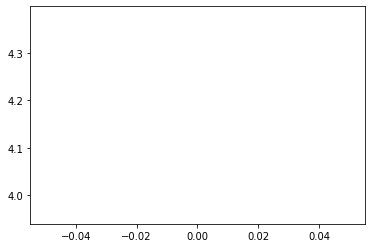

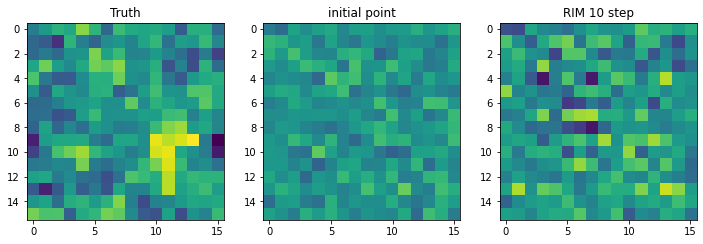

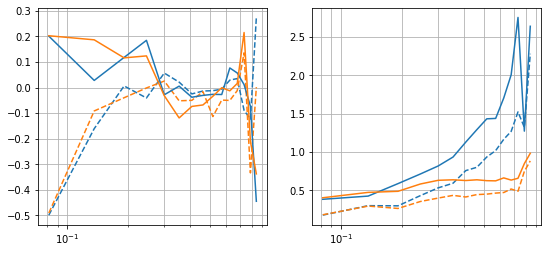

Time taken for 10 iterations :  17.18997812271118
Loss at iteration 10 :  2.3515224
Time taken for 10 iterations :  16.837643146514893
Loss at iteration 20 :  2.177615


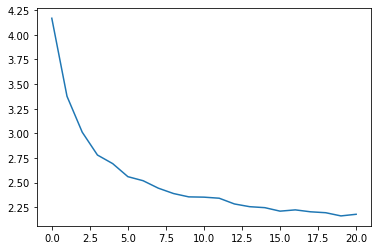

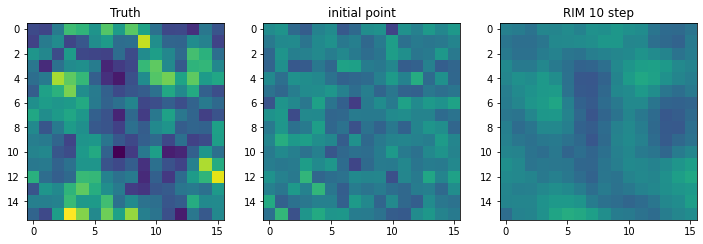

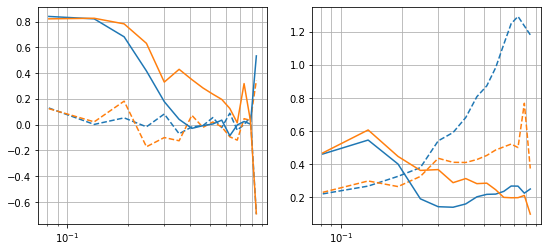

Time taken for 10 iterations :  17.551034688949585
Loss at iteration 30 :  2.0356653
Time taken for 10 iterations :  16.66294550895691
Loss at iteration 40 :  1.9875506


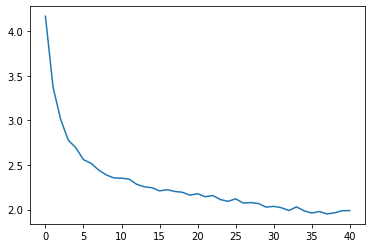

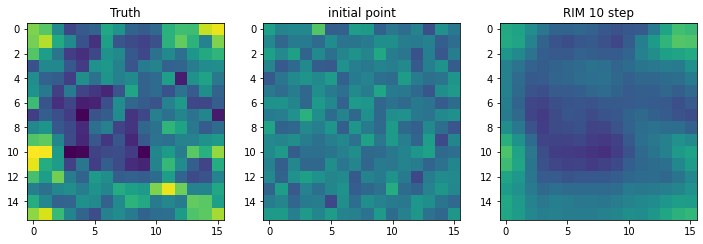

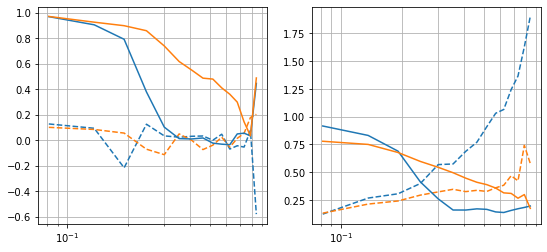

Time taken for 10 iterations :  17.76359724998474
Loss at iteration 50 :  1.9565053
Time taken for 10 iterations :  16.61134433746338
Loss at iteration 60 :  1.9550117


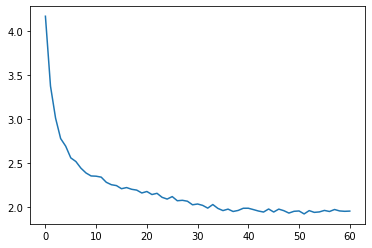

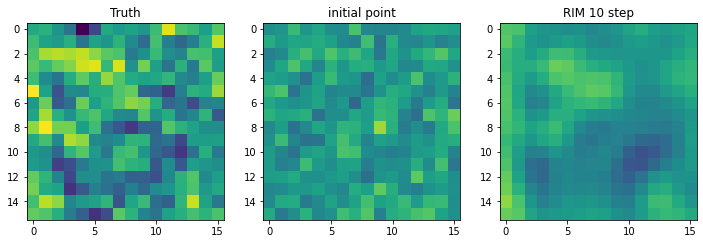

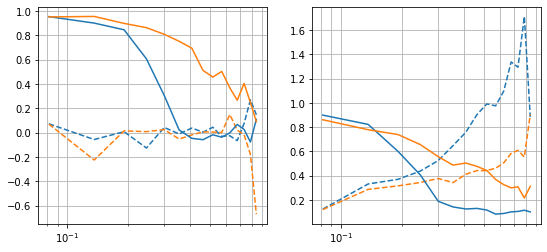

Time taken for 10 iterations :  17.480633974075317
Loss at iteration 70 :  1.8721454
Time taken for 10 iterations :  16.369762420654297
Loss at iteration 80 :  1.863934


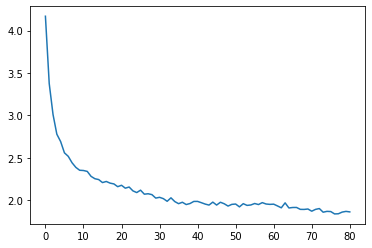

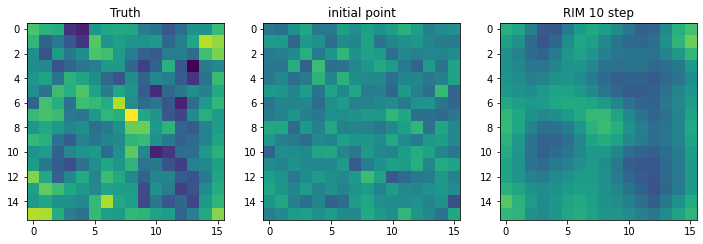

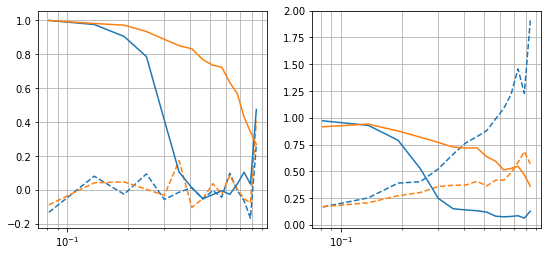

Time taken for 10 iterations :  17.764913320541382
Loss at iteration 90 :  1.8501858
Time taken for 10 iterations :  16.515485525131226
Loss at iteration 100 :  1.825393


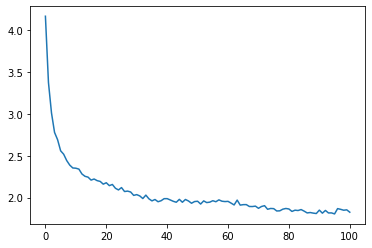

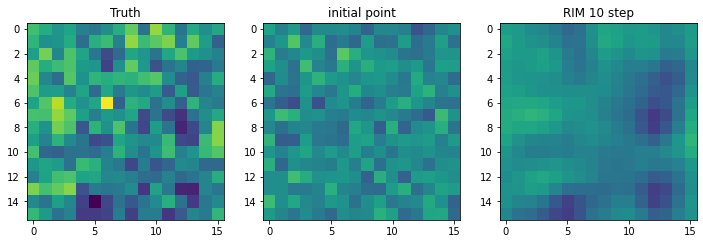

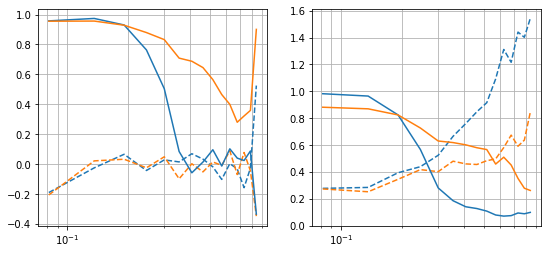

Learning rate = 1.000e-04
Time taken for 10 iterations :  2.7225427627563477
Loss at iteration 0 :  1.8827488


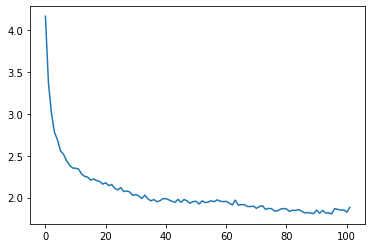

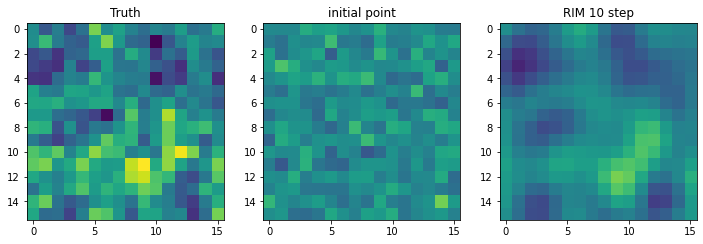

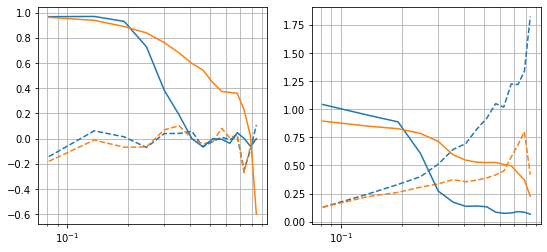

Time taken for 10 iterations :  17.817437887191772
Loss at iteration 10 :  1.818459
Time taken for 10 iterations :  16.730159044265747
Loss at iteration 20 :  1.8084668


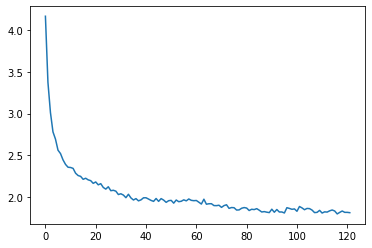

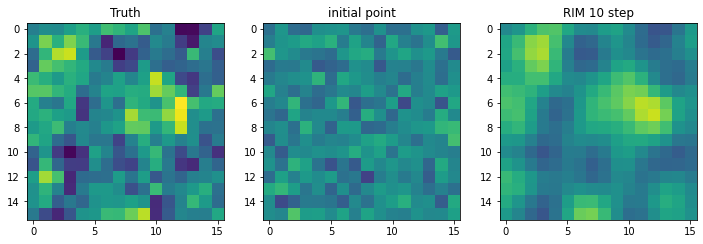

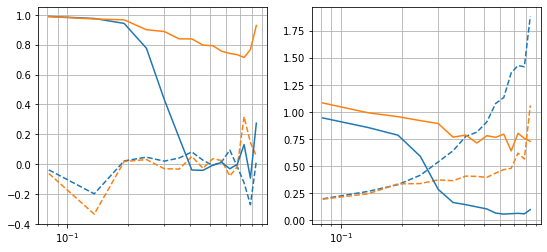

Time taken for 10 iterations :  17.805512189865112
Loss at iteration 30 :  1.8068665
Time taken for 10 iterations :  16.54753541946411
Loss at iteration 40 :  1.8003081


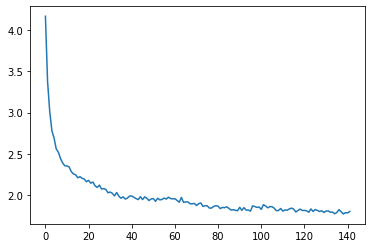

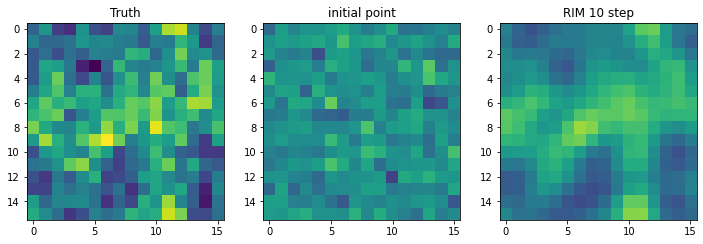

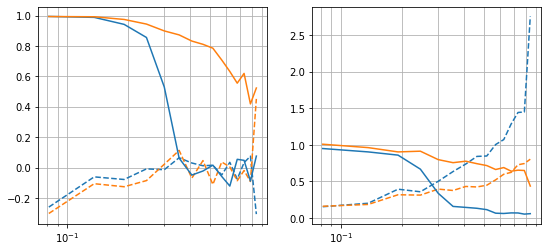

Time taken for 10 iterations :  17.708085536956787
Loss at iteration 50 :  1.7766098
Time taken for 10 iterations :  16.267125844955444
Loss at iteration 60 :  1.7817317


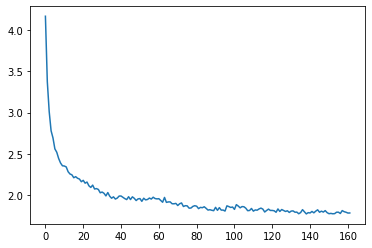

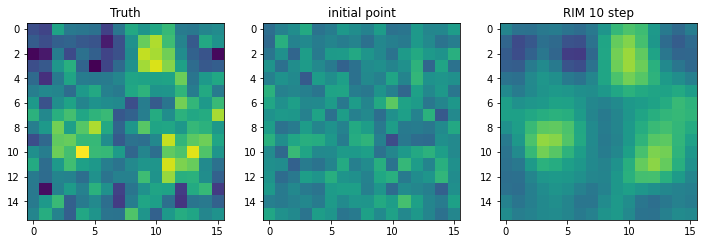

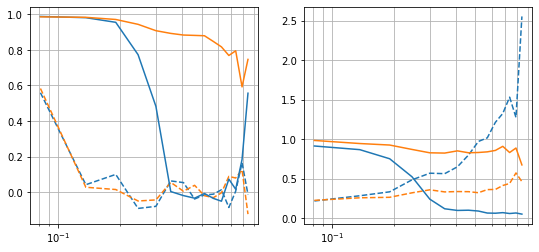

Time taken for 10 iterations :  17.590933084487915
Loss at iteration 70 :  1.8136121
Time taken for 10 iterations :  16.136614561080933
Loss at iteration 80 :  1.787352


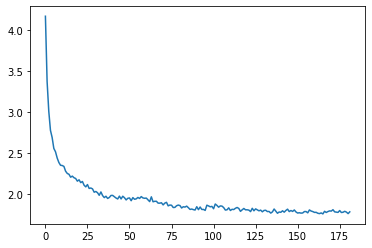

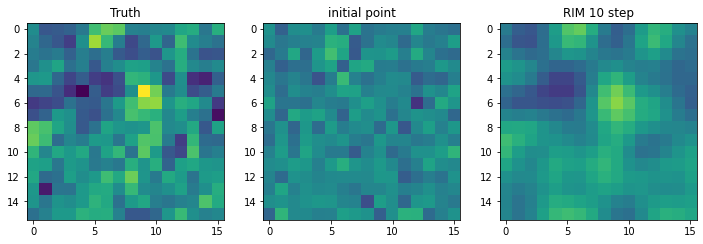

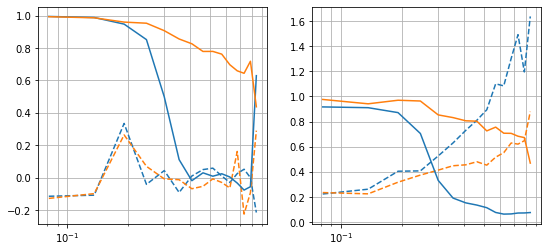

Time taken for 10 iterations :  17.433621883392334
Loss at iteration 90 :  1.767981
Time taken for 10 iterations :  16.315448760986328
Loss at iteration 100 :  1.7784721


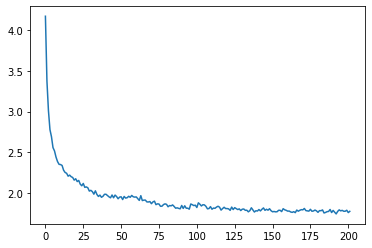

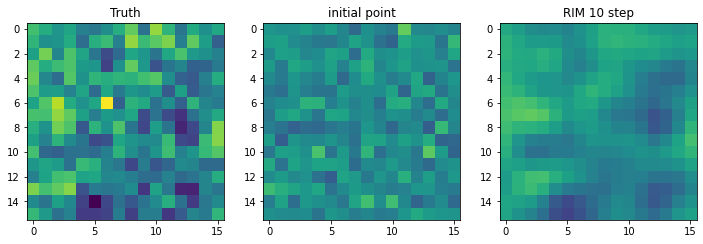

In [ ]:
piter = 10
testiter = 20

start = time.time()

# Create an optimizer for Adam.                                                                                                                           
iterweights = np.arange(rim_iter+1)/rim_iter *0. + 1.
iterweights = iterweights.reshape(-1, 1, 1, 1, 1).astype(float32)


# @tf.function
def rim_train(x_true, x_init, y):
    with tf.GradientTape() as tape:
        x_pred, states = testrim(x_init, y, recon_noanneal_grad)
        res  = (x_true - x_pred)
        #
        loss = tf.reduce_mean(iterweights*tf.square(res))
        
    gradients = tape.gradient(loss, testrim.trainable_variables)
    return loss, gradients
        
    
    
lrs = [0.001, 0.0001, 0.0005]
liters = [101, 101, 101]
for il in range(3):
    print('Learning rate = %0.3e'%lrs[il])
    opt = tf.keras.optimizers.Adam(learning_rate=lrs[il])
    
    for i in range(liters[il]):
        idx = np.random.randint(0, traindata.shape[0], 16)
        xx, yy = traindata[idx, 0].astype(float32), traindata[idx, 1].astype(float32), 
        x_init = np.random.normal(size=xx.size).reshape(xx.shape).astype(float32)
        #x_init = train_xinits[idx]
        #x_init = xinitrecons_train[idx, 0]


        loss, gradients = rim_train(x_true=tf.constant(xx), 
                                x_init=tf.constant(x_init), 
                                y=tf.constant(yy))

        losses.append(loss.numpy())    
        opt.apply_gradients(zip(gradients, testrim.trainable_variables))

        if i%piter == 0: 
            print("Time taken for %d iterations : "%piter, time.time() - start)
            print("Loss at iteration %d : "%i, losses[-1])
            start = time.time()
        if i%testiter == 0: 
            plt.plot(losses)
            plt.show()
            plt.close()
            test_callback()


In [553]:
# gg = recon_noanneal_grad(tf.constant(np.random.normal(size=yy.size).reshape(yy.shape).astype(float32)), tf.constant(yy)).numpy()
# (gg.max(), gg.min(), gg.mean(), gg.std())

In [ ]:
plt.plot(losses)
# plt.semilogx()
plt.loglog()
plt.grid(which='both')

In [ ]:
# idx = np.random.randint(0, traindata.shape[0], 1)
# xx, yy = traindata[idx, 0].astype(float32), traindata[idx, 1].astype(float32), 
# x_init = xinitrecons_train[idx, 0]

idx = np.random.randint(0, testdata.shape[0], 1)
xx, yy = testdata[idx, 0].astype(float32), testdata[idx, 1].astype(float32), 
# x_init = yy.copy() - 1
# x_init = pred2.copy()
# x_init = xinitrecons_test[idx, 0]
x_init = np.random.normal(size=xx.size).reshape(xx.shape).astype(float32)

adam = myAdam(rim_iter)
pred2 = adam(x_init=tf.constant(x_init), 
                      y=tf.constant(yy), 
                      grad_fn=recon_noanneal_grad)[-1].numpy()

adam = myAdam(rim_iter*10)
pred3 = adam(x_init=tf.constant(x_init), 
                      y=tf.constant(yy), 
                      grad_fn=recon_noanneal_grad)[-1].numpy()


out, states = testrim2(x_init=tf.constant(x_init), 
                      y=tf.constant(yy), 
                      grad_fn=recon_noanneal_grad)

out = out.numpy()
pred = out[-1]
cstate = out[1][:, 0]


In [ ]:
fig, ax = plt.subplots(1, 4, figsize = (12, 4))
vmin, vmax = xx[0].sum(axis=0).min(), xx[0].sum(axis=0).max()
print(vmin, vmax)
# vmin, vmax=None,None
ax[0].imshow(xx[0].sum(axis=0), vmin=vmin, vmax=vmax)
ax[0].set_title('Truth')
ax[1].imshow(x_init[0].sum(axis=0), vmin=vmin, vmax=vmax)
ax[1].set_title('initial point')
ax[2].imshow(pred[0].sum(axis=0), vmin=vmin, vmax=vmax)
ax[2].set_title('RIM %d step'%rim_iter)
ax[3].imshow(pred3[0].sum(axis=0), vmin=vmin, vmax=vmax)
ax[2].set_title('Adam %d step'%(10*rim_iter))

No handles with labels found to put in legend.


Text(0.5, 1.0, 'transfer Function')

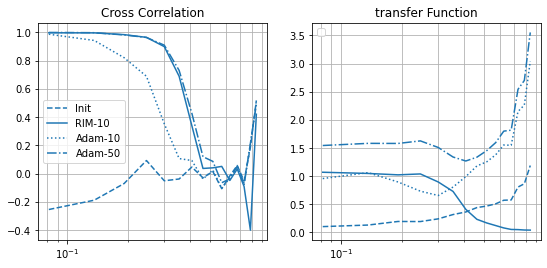

In [604]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

k, pks = get_ps([out[0], pm(out[0]).numpy()], [xx, yy])
for i in range(1):
    ax[0].plot(k, pks[i][2]/(pks[i][0]*pks[i][1])**0.5, 'C%d--'%i, label='Init')
    ax[1].plot(k, (pks[i][0]/pks[i][1])**0.5, 'C%d--'%i)

k, pks = get_ps([out[-1], pm(out[-1]).numpy()], [xx, yy])
for i in range(1):
    ax[0].plot(k, pks[i][2]/(pks[i][0]*pks[i][1])**0.5, 'C%d'%i, label='RIM-%d'%rim_iter)
    ax[1].plot(k, (pks[i][0]/pks[i][1])**0.5, 'C%d'%i)

k, pks = get_ps([pred2, pm(pred2).numpy()], [xx, yy])
for i in range(1):
    ax[0].plot(k, pks[i][2]/(pks[i][0]*pks[i][1])**0.5, 'C%d:'%i, label='Adam-%d'%rim_iter)
    ax[1].plot(k, (pks[i][0]/pks[i][1])**0.5, 'C%d:'%i)

k, pks = get_ps([pred3, pm(pred3).numpy()], [xx, yy])
for i in range(1):
    ax[0].plot(k, pks[i][2]/(pks[i][0]*pks[i][1])**0.5, 'C%d-.'%i, label='Adam-%d'%(10*rim_iter))
    ax[1].plot(k, (pks[i][0]/pks[i][1])**0.5, 'C%d-.'%i)

for axis in ax: 
    axis.semilogx()
    axis.grid(which='both')
    axis.legend()
#     axis.legend(bbox_to_anchor=(2.6, 1))
ax[0].set_title('Cross Correlation')
ax[1].set_title('transfer Function')

In [ ]:
testrim.save_weights()

In [581]:
ii = -1
out[ii, 0].min(), out[ii, 0].max(), out[ii, 0].mean(), out[ii, 0].std()

(-3.4938767, 2.9931326, -0.010357074, 1.0212513)

In [625]:
# savepath = './rim-models/L%04d_N%03d_T%02d/'%(bs, nc, nsteps)
# testrim.save_weights(savepath, overwrite=False)
# testrim2 = myRIM3D(cell, output_layer, input_layer, lrgrad,  niter=rim_iter, optimizer=None)
# testrim2.load_weights(savepath)

[WARNING] ./rim-models/L0100_N016_T02/.index already exists - overwrite? [y/n]n


In [611]:
# for i in range(out.shape[0]):
#     im = plt.imshow(out[i, 0].sum(axis=0))
#     plt.colorbar(im)
#     plt.title(i)
#     plt.show()
    

In [402]:
# gradlist = []
# gradlist.append(recon_noanneal_grad(tf.constant(xx), tf.constant(yy)))
# for i in range(niter):
#     gradlist.append(recon_noanneal_grad(tf.constant(out[i]), tf.constant(yy)))

In [ ]:
def summary(x):
    print(x.min(), x.max(), x.mean(), x.std())
    
for j in gradlist:summary(j.numpy())

In [ ]:
# plt.hist(gradlist[0].numpy().flatten(), alpha=0.5, density=True)
plt.hist(out[0].flatten(), alpha=0.5, density=True)
plt.hist(out[1].flatten(), alpha=0.5, density=True)
plt.show()
plt.hist(gradlist[1].numpy().flatten(), alpha=0.5, density=True)
plt.hist(gradlist[-1].numpy().flatten(), alpha=0.5, density=True)

In [105]:
for j in out:summary(j)

-2.876116 2.7669501 -0.10401599 0.79923224
-1.4852052 1.9702345 0.19912246 0.4171117
-1.82972 1.23369 -0.1572816 0.34053513
-1.1363453 0.7931309 -0.11329524 0.23624866
-0.75516593 0.6607746 -0.05694835 0.16897562
-0.52650225 0.5538628 0.06849842 0.1209618
-0.42324495 0.49213842 0.08652802 0.10156119
-0.3602211 0.45911318 -0.0074680997 0.065877154
-0.26886174 0.39971864 -0.017714445 0.059290618
-0.22499639 0.39419067 -0.03682585 0.05302635
-0.1963042 0.40359205 -0.032712128 0.046841778
-0.19634399 0.41960752 -0.02833075 0.04502737
-0.18710575 0.43057218 -0.029404024 0.043092865
-0.17175531 0.43928942 -0.02578323 0.04250669
-0.18327315 0.44353962 -0.026505928 0.043076064
-0.19521713 0.44623384 -0.026834521 0.04315577
-0.20444599 0.44808 -0.026767565 0.04338202
-0.20963271 0.45114332 -0.027793717 0.0435065
-0.2112278 0.45437253 -0.027931139 0.0433451
-0.21021159 0.45841318 -0.027899185 0.04328741
-0.20820087 0.46158212 -0.028052796 0.043232635
